# Object Detection with Yolov3


![cover](https://bitmovin.com/wp-content/uploads/2019/08/Object_detection_Blog_Image_Q3_19.jpg)




## Load Pretrained Model

In [2]:
import struct
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import add, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from numpy import expand_dims

In [3]:
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        if conv['stride'] > 1: x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'],
                   conv['kernel'],
                   strides=conv['stride'],
                   padding='valid' if conv['stride'] > 1 else 'same',  # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']),
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
    return add([skip_connection, x]) if skip else x


def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))
    # Layer  0 => 4
    x = _conv_block(input_image,
                    [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                     {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                     {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                     {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter': 64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
    # Layer  9 => 11
    x = _conv_block(x, [{'filter': 64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [
            {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16 + i * 3},
            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17 + i * 3}])
    skip_36 = x
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [
            {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41 + i * 3},
            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42 + i * 3}])
    skip_61 = x
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter': 512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [
            {'filter': 512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66 + i * 3},
            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67 + i * 3}])
    # Layer 75 => 79
    x = _conv_block(x, [{'filter': 512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter': 512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter': 512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}],
                    skip=False)
    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 80},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False,
                               'layer_idx': 81}], skip=False)
    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}],
                    skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])
    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}],
                    skip=False)
    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False,
                               'layer_idx': 93}], skip=False)
    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 96}],
                    skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])
    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True,
                                'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,
                                'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True,
                                'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,
                                'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True,
                                'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False,
                                'layer_idx': 105}], skip=False)
    model = Model(input_image, [yolo_82, yolo_94, yolo_106])
    return model


class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major, = struct.unpack('i', w_f.read(4))
            minor, = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))
            if (major * 10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)
            transpose = (major > 1000) or (minor > 1000)
            binary = w_f.read()
        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')

    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset - size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))
                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))
                    size = np.prod(norm_layer.get_weights()[0].shape)
                    beta = self.read_bytes(size)  # bias
                    gamma = self.read_bytes(size)  # scale
                    mean = self.read_bytes(size)  # mean
                    var = self.read_bytes(size)  # variance
                    weights = norm_layer.set_weights([gamma, beta, mean, var])
                if len(conv_layer.get_weights()) > 1:
                    bias = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2, 3, 1, 0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2, 3, 1, 0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))

    def reset(self):
        self.offset = 0
# define the model
model = make_yolov3_model()
# load the model weights
weight_reader = WeightReader('yolov3 (2).weights')
# set the model weights into the model
weight_reader.load_weights(model)
# # save the model to file
model.save('model.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, None, None, 3 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, None, None, 3 0           bnorm_0[0][0]                    
______________________________________________________________________________________________

## Make Preditions

In [5]:
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

In [6]:
IMAGE_WIDTH=416
IMAGE_HEIGHT=416
def load_and_preprocess_image(path,shape):
  image=tf.io.read_file(path)
  width,height=load_img(path).size
  image=tf.image.decode_jpeg(image,channels=3)
  image=tf.image.resize(image, shape)
  image/=255
  return image,width,height

Image comes from (https://www.strathcona.ca/transportation-roads/traffic/traffic-signals/)

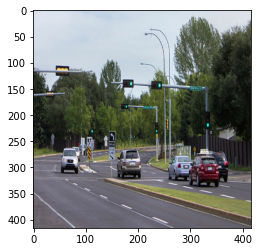

In [7]:
photo_filename='traffic.jpg'
_image, image_w, image_h=load_and_preprocess_image(photo_filename,[IMAGE_WIDTH,IMAGE_HEIGHT])
plt.imshow(_image)

In [8]:
image = expand_dims(_image, 0)
yhat = model.predict(image)
print([a.shape for a in yhat])

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


## Process output matrix

In [9]:
# This cell is based on https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/
class BoundBox:
	'''
	Objects of boxes. (xmin,ymin) represents the upleft coordinate of the box while (xmax,ymax) means downright one.
	'''
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1
 
	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)
 
		return self.label
 
	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]
 
		return self.score

def _sigmoid(x):
	return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
 
	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			# if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes

In [10]:
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
boxes = list()
for i in range(len(yhat)):
	boxes += decode_netout(yhat[i][0], anchors[i], net_h=IMAGE_HEIGHT, net_w=IMAGE_WIDTH)

for i in range(len(boxes)):
	x_offset, x_scale = (IMAGE_WIDTH - IMAGE_WIDTH)/2./IMAGE_HEIGHT, float(IMAGE_WIDTH)/IMAGE_WIDTH
	y_offset, y_scale = (IMAGE_HEIGHT - IMAGE_HEIGHT)/2./IMAGE_HEIGHT, float(IMAGE_HEIGHT)/IMAGE_HEIGHT
	boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
	boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
	boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
	boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [11]:
len(boxes)

10647

## Boxes Filters

From the sections above, it is clear to see that there are over ten thousands of boxes detected. This next step is to filter the boxes with very low confidence by using threshold.

In [12]:
def box_filter(boxes,labels,threshold_socre):
	valid_boxes=[]
	valid_labels=[]
	valid_scores=[]
	for box in boxes:
		for i in range(len(labels)):
			if box.classes[i] > threshold_socre:
				valid_boxes.append(box)
				valid_labels.append(labels[i])
				valid_scores.append(box.classes[i])
		
	return (valid_boxes,valid_labels,valid_scores)

In [13]:
valid_data= box_filter(boxes, labels, threshold_socre=0.6)

## Draw all the boxes

In [14]:
def draw_boxes(filename, valid_data):

	data = pyplot.imread(filename)
	pyplot.imshow(data)
	ax = pyplot.gca()
	for i in range(len(valid_data[0])):
		box = valid_data[0][i]
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		width, height = x2 - x1, y2 - y1
		rect = Rectangle((x1, y1), width, height, fill=False, color='white')
		ax.add_patch(rect)
		print(valid_data[1][i], valid_data[2][i])
		label = "%s (%.3f)" % (valid_data[1][i], valid_data[2][i])
		pyplot.text(x1, y1, label, color='white')
	pyplot.show()

car 0.9799808
car 0.90150255
car 0.9822434
car 0.8228119
car 0.9342799
car 0.93157935
car 0.98184437
car 0.9982241
car 0.981548
car 0.9050932
car 0.76686317
car 0.98158294
car 0.9231706
car 0.6597401
car 0.9845722
car 0.98843783
car 0.88082856
traffic light 0.6188273
traffic light 0.75971955
traffic light 0.70200676
traffic light 0.87137073
traffic light 0.964606
traffic light 0.77623135
traffic light 0.83280665
car 0.6020882
car 0.7852917


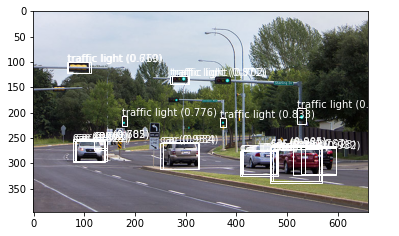

In [15]:
draw_boxes(photo_filename,valid_data)

## Non-max Seppression, NMS

In [16]:
def encoder_dic(valid_data):
  data_dic={}
  (valid_boxes,valid_labels,valid_scores)=valid_data
  for box, label,score in zip(valid_boxes,valid_labels,valid_scores):
    if label not in data_dic:
      data_dic[label]=[[score,box,'kept']]
    else:
      data_dic[label].append([score,box,'kept'])
      
  return data_dic
dic=encoder_dic(valid_data)

In [17]:
def decode_box_coor(box):
  return (box.xmin, box.ymin,box.xmax, box.ymax )

def iou(box1, box2):
  (box1_x1, box1_y1, box1_x2, box1_y2) = decode_box_coor(box1)
  (box2_x1, box2_y1, box2_x2, box2_y2) = decode_box_coor(box2)

  xi1 = max(box1_x1,box2_x1)
  yi1 = max(box1_y1,box2_y1)
  xi2 = min(box1_x2,box2_x2)
  yi2 = min(box1_y2,box2_y2)
  inter_width = xi2-xi1
  inter_height = yi2-yi1
  inter_area = max(inter_height,0)*max(inter_width,0)

  box1_area = (box1_x2-box1_x1)*(box1_y2-box1_y1)
  box2_area = (box2_x2-box2_x1)*(box2_y2-box2_y1)
  union_area = box1_area+box2_area-inter_area 

  iou = inter_area/union_area
  
  return iou

def do_nms(data_dic, nms_thresh):
  final_boxes,final_scores,final_labels=list(),list(),list()
  for label in data_dic:
    scores_boxes=sorted(data_dic[label],reverse=True)
    for i in range(len(scores_boxes)):
      if scores_boxes[i][2]=='removed': continue
      for j in range(i+1,len(scores_boxes)):
        if iou(scores_boxes[i][1],scores_boxes[j][1]) >= nms_thresh:
          scores_boxes[j][2]="removed"

    for e in scores_boxes:
      print(label+' '+str(e[0]) + " status: "+ e[2])
      if e[2]=='kept':
        final_boxes.append(e[1])
        final_labels.append(label)
        final_scores.append(e[0])
    

  return (final_boxes,final_labels,final_scores)

In [18]:
final_data=do_nms(dic, 0.7)

car 0.9982241 status: kept
car 0.98843783 status: kept
car 0.9845722 status: removed
car 0.9822434 status: kept
car 0.98184437 status: removed
car 0.98158294 status: kept
car 0.981548 status: removed
car 0.9799808 status: removed
car 0.9342799 status: kept
car 0.93157935 status: removed
car 0.9231706 status: removed
car 0.9050932 status: removed
car 0.90150255 status: removed
car 0.88082856 status: removed
car 0.8228119 status: removed
car 0.7852917 status: kept
car 0.76686317 status: kept
car 0.6597401 status: removed
car 0.6020882 status: removed
traffic light 0.964606 status: kept
traffic light 0.87137073 status: kept
traffic light 0.83280665 status: kept
traffic light 0.77623135 status: kept
traffic light 0.75971955 status: kept
traffic light 0.70200676 status: removed
traffic light 0.6188273 status: removed


car 0.9982241
car 0.98843783
car 0.9822434
car 0.98158294
car 0.9342799
car 0.7852917
car 0.76686317
traffic light 0.964606
traffic light 0.87137073
traffic light 0.83280665
traffic light 0.77623135
traffic light 0.75971955


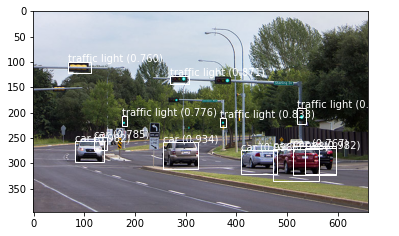

In [19]:
draw_boxes(photo_filename,final_data)

### Use Keras "non_max_suppression"

In [20]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    nms_indices = tf.image.non_max_suppression(scores=scores,boxes=boxes,max_output_size=max_boxes,iou_threshold=iou_threshold)

    scores = K.gather(scores,nms_indices)
    boxes = K.gather(boxes,nms_indices)
    classes = K.gather(classes,nms_indices)

    return scores, boxes, classes

## Other Results

In [21]:
def showresults(path):
  _image,width,height=load_and_preprocess_image(path,[IMAGE_WIDTH,IMAGE_HEIGHT])
  image = expand_dims(_image, 0)
  yhat = model.predict(image)
  boxes = list()
  for i in range(len(yhat)):
	  boxes += decode_netout(yhat[i][0], anchors[i], net_h=IMAGE_HEIGHT, net_w=IMAGE_WIDTH)
  for i in range(len(boxes)):
    x_offset, x_scale = (IMAGE_WIDTH - IMAGE_WIDTH)/2./IMAGE_HEIGHT, float(IMAGE_WIDTH)/IMAGE_WIDTH
    y_offset, y_scale = (IMAGE_HEIGHT - IMAGE_HEIGHT)/2./IMAGE_HEIGHT, float(IMAGE_HEIGHT)/IMAGE_HEIGHT
    boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
    boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
    boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
    boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
  valid_data= box_filter(boxes, labels, threshold_socre=0.6)
  dic=encoder_dic(valid_data)
  final_data=do_nms(dic, 0.7)
  draw_boxes(path,final_data)

zebra 0.998504 status: kept
zebra 0.9980972 status: removed
zebra 0.99749166 status: removed
zebra 0.99720347 status: removed
zebra 0.97361493 status: kept
zebra 0.9625325 status: kept
zebra 0.94921255 status: kept
zebra 0.9479588 status: removed
zebra 0.92289156 status: kept
zebra 0.88756204 status: removed
zebra 0.7587729 status: removed
zebra 0.7129495 status: removed
zebra 0.66869545 status: removed
zebra 0.998504
zebra 0.97361493
zebra 0.9625325
zebra 0.94921255
zebra 0.92289156


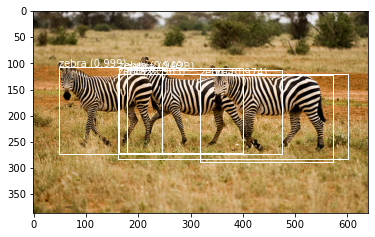

In [22]:
showresults('zebra.jpg')

horse 0.9981355 status: kept
horse 0.9928219 status: removed
horse 0.94988006 status: removed
horse 0.8879705 status: removed
horse 0.7980072 status: removed
horse 0.78876853 status: removed
horse 0.63089937 status: removed
horse 0.9981355


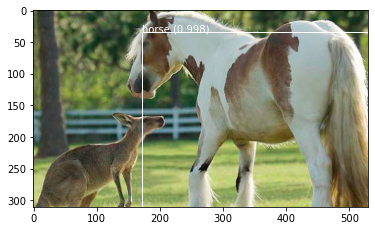

In [23]:
showresults('kangaroo.png')